In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = os.path.join(r'C:\Users\theod\Desktop\Jobs\Arenko', 'assessment_data.csv')
data = pd.read_csv(data_dir)
data.shape

(14640, 30)

In [3]:
# first thing we need is to convert the date
data.date_start = [datetime.fromisoformat(date).timestamp() for date in data.date_start]

In [4]:
test = pd.DataFrame()
train = data
# splitting training data and test data: we want to take 1 day every 2 days for the testing
for i in range(100):
    test = pd.concat([test, data.iloc[96*(i+1):48+96*(i+1),]], axis=0)
mask = ~data.index.isin(test.index)
train = data.loc[mask]
train.shape, test.shape

((9840, 30), (4800, 30))

# Data Analysis

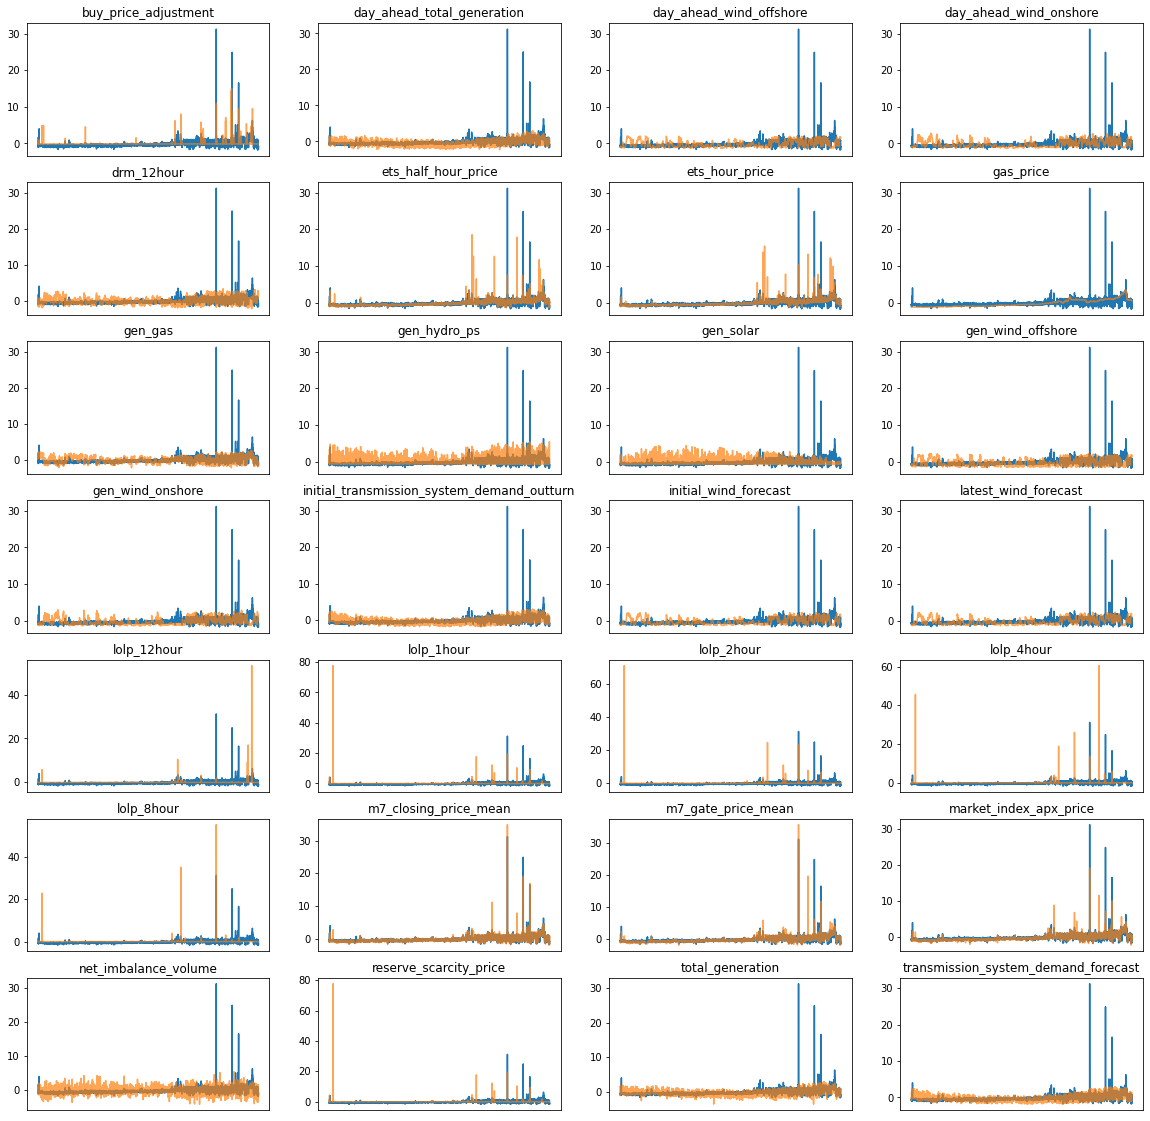

In [5]:
# plot the labels to see what we're dealing with: 
# we plot each feature with the labels to see which features are relevant
plt.figure(figsize=(20,20))
train_ = train.drop('system_buy_price', axis=1)

# we whiten the data before plotting
w = lambda d: (d - d.mean())/d.std()
for i in range(28):
    plt.subplot(7, 4, i+1)
    plt.title(train_.columns[i+1])
    plt.plot(train.date_start, w(train.system_buy_price))
    plt.plot(train.date_start, w(train_.iloc[:, i+1]), alpha=0.7)
    plt.xticks([])

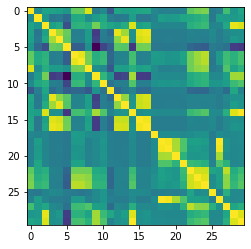

In [100]:
# lets look at the correlation matrix
plt.imshow(train.corr());

In [99]:
# we want to find the best correlation to the price, negative correlation is still important
train.corr().system_buy_price.sort_values(axis=0, ascending=False, key=lambda x: abs(x))

system_buy_price                              1.000000
m7_closing_price_mean                         0.818649
m7_gate_price_mean                            0.690291
market_index_apx_price                        0.677718
gas_price                                     0.508018
date_start                                    0.455361
ets_hour_price                                0.441192
ets_half_hour_price                           0.433052
lolp_8hour                                    0.358377
net_imbalance_volume                          0.341757
transmission_system_demand_forecast           0.336137
initial_transmission_system_demand_outturn    0.334056
day_ahead_total_generation                    0.272179
total_generation                              0.257717
gen_gas                                       0.228151
gen_hydro_ps                                  0.201617
buy_price_adjustment                          0.188777
gen_solar                                    -0.160233
lolp_1hour

# With NNs

In [103]:
# we convert our data to numpy for computations
y = train.system_buy_price.to_numpy()
X = train.drop(['system_buy_price'], axis=1).to_numpy()
labels_test = test.system_buy_price.to_numpy()
features_test = test.drop(['system_buy_price'], axis=1).to_numpy()

In [7]:
# baseline linear nn
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(29, 100), nn.ReLU(), 
                                    nn.Linear(100, 29), nn.ReLU(),
                                    nn.Linear(29, 10), nn.ReLU(),
                                    nn.Linear(10, 1)
                                   )
    def forward(self, x):
        x = x.view(-1, 29)
        out = self.layers(x)
        return out

Epoch 0, train loss = 1.9155e+16
Epoch 20, train loss = 1.9619e+08
Epoch 40, train loss = 1.8163e+08
Epoch 60, train loss = 1.8164e+08
Epoch 80, train loss = 1.7699e+08


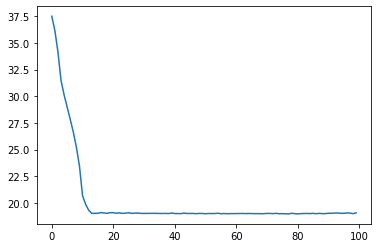

In [26]:
net = network().to(device)
opt = torch.optim.Adam(net.parameters(), lr=0.0001)
epochs = 100
losses = []
lossfunc = nn.MSELoss()

# convert our numpy data to torch and cuda
ytensor = torch.Tensor(y).to(device)
Xtensor = torch.Tensor(X).to(device)

# we want to batch to prevent overfitting, create data object for torch dataloader
class data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        _y = self.Y[index]
        return _x, _y

# create data loader
dataloader = DataLoader(data(Xtensor, ytensor), batch_size=500, shuffle=True)

for epoch in range(epochs):
    epoch_loss = 0.
    for X_t, y_t in dataloader:
        opt.zero_grad()
        yhat = net(X_t)
        loss = lossfunc(yhat.squeeze(), y_t)
        loss.backward()
        opt.step()
        epoch_loss += loss.item() * X_t.shape[0]/len(iter(dataloader))
    losses.append(epoch_loss)
    if epoch%20==0:
        print('Epoch %d, train loss = %0.4e' % (epoch, epoch_loss))   
# plot log losses of each epoch
plt.plot(np.log(losses));

In [27]:
# testing 
Xtest, ytest = torch.Tensor(features_test).to(device), torch.Tensor(labels_test).to(device)
with torch.no_grad():
    yhat = net(Xtest)
    MSE = lossfunc(yhat.squeeze(), ytest)
    print(MSE.item())

322479.78125


In [10]:
# lstms are more suited to time-series data, linear network decorrelates time
class lstm(nn.Module):
    def __init__(self, hl=10):
        super().__init__()
        self.hl = hl
        self.lstm1 = nn.LSTMCell(29, self.hl)
        self.linear = nn.Sequential(nn.Linear(self.hl, self.hl), nn.ReLU(),
                                    nn.Linear(self.hl, self.hl), nn.ReLU(),
                                    nn.Linear(self.hl, 1))
        
    def forward(self, X, future=0):
        outputs, n_samples = [], 1
        # we initialise the memory with 0s
        h_t = torch.zeros(n_samples, self.hl, dtype=torch.float32).to(device)
        c_t = torch.zeros(n_samples, self.hl, dtype=torch.float32).to(device)
        
        for data_t in X.split(1, dim=0):
            # we loop though the data in order
            h_t, c_t = self.lstm1(data_t, (h_t, c_t)) 
            output = self.linear(h_t)
            outputs.append(output)
            
        for i in range(future):
            # in case we want to predict future data
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        outputs = torch.cat(outputs, dim=0)
        return outputs

Epoch 0, train loss = 3.2899e+04
Epoch 10, train loss = 1.4797e+04
Epoch 20, train loss = 1.4857e+04
Epoch 30, train loss = 1.4849e+04
Epoch 40, train loss = 1.4847e+04


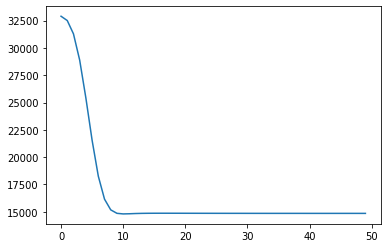

In [11]:
# we set up the LSTM with linear layers of size 10
net = lstm(10).to(device)
opt = torch.optim.Adam(net.parameters())
epochs = 50
losses = []
lossfunc = nn.MSELoss()

# converting our data to torch and CUDA
ytensor = torch.Tensor(y).to(device)
Xtensor = torch.Tensor(X).to(device)

# we loop through the data points in order because it's a time series but we still do it in batches
for epoch in range(epochs):
    epoch_loss = 0.
    for i in range(99):
        X_t, y_t = Xtensor[100*i:100*(i+1),:], ytensor[100*i:100*(i+1)]
        opt.zero_grad()
        yhat = net(X_t).view(-1, )
        loss = lossfunc(yhat, y_t)
        loss.backward()
        opt.step()
        epoch_loss += loss.item() * X_t.shape[0]/train.shape[0]
    losses.append(epoch_loss)
    if epoch%10==0:
        print('Epoch %d, train loss = %0.4e' % (epoch, epoch_loss))   
plt.plot(losses);

In [12]:
# testing 
Xtest, ytest = torch.Tensor(features_test).to(device), torch.Tensor(labels_test).to(device)
with torch.no_grad():
    yhat = net(Xtest)
    MSE = lossfunc(yhat.squeeze(), ytest)
    print(MSE.item())

40142.60546875


Much better than linear model, (322 480 MSE error)

# With GPs

I didn't have time to finish this due to a lack of time, I hope that's alright.

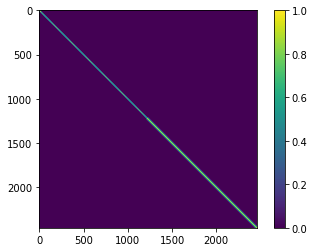

In [75]:
# with GPs, we take a quarter of the data (every 4 data points) because inversion is very slow
def kernel(X,Z, sigma=1e-10):
    if len(X.shape)<2:
        X = X.reshape(1,-1)
        Z = Z.reshape(-1, 1)
        return np.exp(-sigma*(X-Z)**2)
    return np.exp(-sigma*(cdist(X,Z))**2)

Kxx = kernel(X[::4,0], X[::4, 0])
plt.imshow(Kxx)
plt.colorbar();

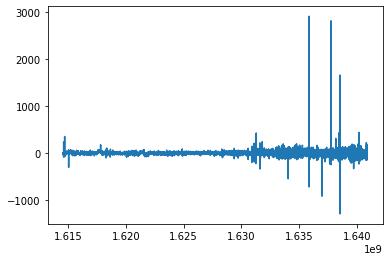

In [101]:
# get the residuals
l = 0 # no regulariser for now
theta = np.linalg.pinv(X.T @ X + l*X.shape[0]*np.eye(X.shape[1]))@ X.T @ y
residuals = y-X@theta
plt.plot(X[:,0], residuals);

In [85]:
# doesnt work...

# time domain we want to look at
# domain = np.linspace(1.615e9,1.64e9, 2460)
# K = kernel(domain, domain)
# Kx = kernel(domain, X[::4,0])
# Kxx_inv = np.linalg.pinv(Kxx)

# mean = Kx @ Kxx_inv @ residuals[::4]
# Cov = K - Kx @ Kxx_inv @ Kx.T

# make covariance PSD
# CovPSD = np.tril(Cov) @ np.tril(Cov).T + 0.01 * np.eye(Cov.shape[0])

# get samples
# samples = np.random.multivariate_normal(mean, CovPSD, 3).T

# get std for error plotting
# std = np.diag(Cov).flatten()**0.5
# plt.plot(X[::4,0],(X[::4]@theta)[:,None]+samples)